<a href="https://colab.research.google.com/github/Ajah-Stephen/MSCPROJECT/blob/main/MSCPROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [3]:
rolls = pd.read_csv('/content/RR.L.csv')

In [4]:
# Displaying the first few rows of the dataframe to understand its structure
print(rolls.head())

         Date       Open       High        Low      Close  Adj Close   Volume
0  1990-01-30  53.698799  53.698799  53.698799  53.698799  25.111080  6303136
1  1990-01-31  54.304798  54.304798  54.304798  54.304798  25.394464  4854872
2  1990-02-01  54.304798  54.304798  54.304798  54.304798  25.394464  5243504
3  1990-02-02  54.304798  54.304798  54.304798  54.304798  25.394464  3312486
4  1990-02-05  54.914101  54.914101  54.914101  54.914101  25.679398  9469885


In [5]:
rolls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8806 entries, 0 to 8805
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       8806 non-null   object 
 1   Open       8806 non-null   float64
 2   High       8806 non-null   float64
 3   Low        8806 non-null   float64
 4   Close      8806 non-null   float64
 5   Adj Close  8806 non-null   float64
 6   Volume     8806 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 481.7+ KB


In [6]:
rolls.shape

(8806, 7)

**DATA CLEANING AND DATA PREPROCESSING**

In [7]:
# Converting the 'Date' column to datetime format
rolls['Date'] = pd.to_datetime(rolls['Date'])

In [8]:
# Checking for missing values
missing_values = rolls.isnull().sum()
missing_values

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [9]:
# Displaying data types and missing values
rolls.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

**APPLYING EXPLORATORY DATA ANALYSIS**

In [10]:
rolls.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,8806,8806.000000,8806.000000,8806.000000,8806.000000,8806.000000,8.806000e+03
mean,2007-02-08 18:47:49.861458176,148.503190,150.402119,146.577036,148.517906,125.670724,2.555938e+07
min,1990-01-30 00:00:00,23.163799,23.678600,22.048500,22.048500,13.052999,0.000000e+00
25%,1998-07-08 06:00:00,65.373497,66.179953,64.515602,65.240097,38.514699,1.083693e+07
50%,2006-12-24 12:00:00,100.471001,102.650101,98.146103,100.076401,89.790592,1.840933e+07
75%,2015-09-13 06:00:00,222.201401,225.071205,219.455994,222.544495,209.377423,3.203425e+07
max,2024-06-03 00:00:00,459.299988,468.100006,458.600006,460.899994,460.899994,2.934018e+09
std,NaN,103.853493,104.849897,102.813588,103.858884,106.373755,3.908861e+07


Statistic Breakdown:

[A] Count: This is the number of Non-Null values in each of the column
[B] Mean: This is the Average value for each of the column.
[C] Min: This is the minimum value observed in each column
[D] 25% : This is the Percentile (Lower Quartile) value
[E] 50% : This is the Median Percentile value
[F] 75% : This is the Percentile (Upper Quartile) value
[G] Max: This is the maximum value observed in each column
[H] Std: This is the Standard Deviation of each column that measures variability
1. The Mean (Average) closing price is approximately 148.52, while the Maximum closing price seen is 460.90.

2. The Volume traded ranges from 0 (Zero) minimum to 2.93 billion maximum shares.

3. The Adjusted Closing price a standard deviation of approximately 106.37

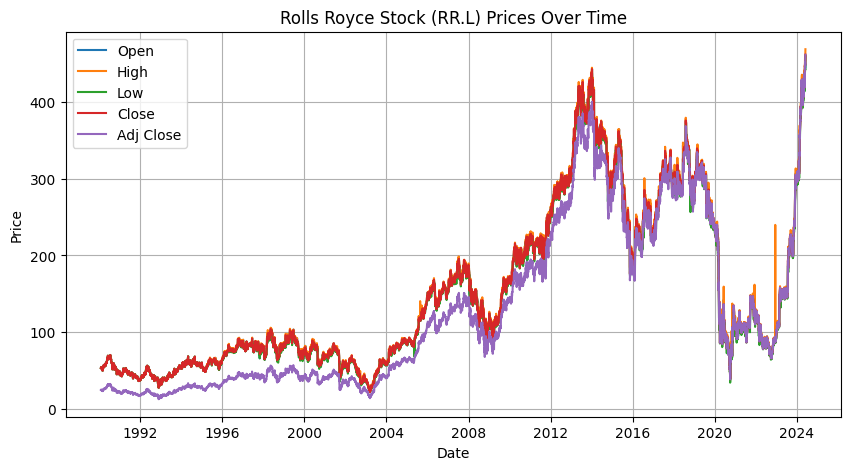

In [11]:
# Ploting time series of stock prices
plt.figure(figsize=(10, 5))
plt.plot(rolls['Date'], rolls['Open'], label='Open')
plt.plot(rolls['Date'], rolls['High'], label='High')
plt.plot(rolls['Date'], rolls['Low'], label='Low')
plt.plot(rolls['Date'], rolls['Close'], label='Close')
plt.plot(rolls['Date'], rolls['Adj Close'], label='Adj Close')
plt.title('Rolls Royce Stock (RR.L) Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

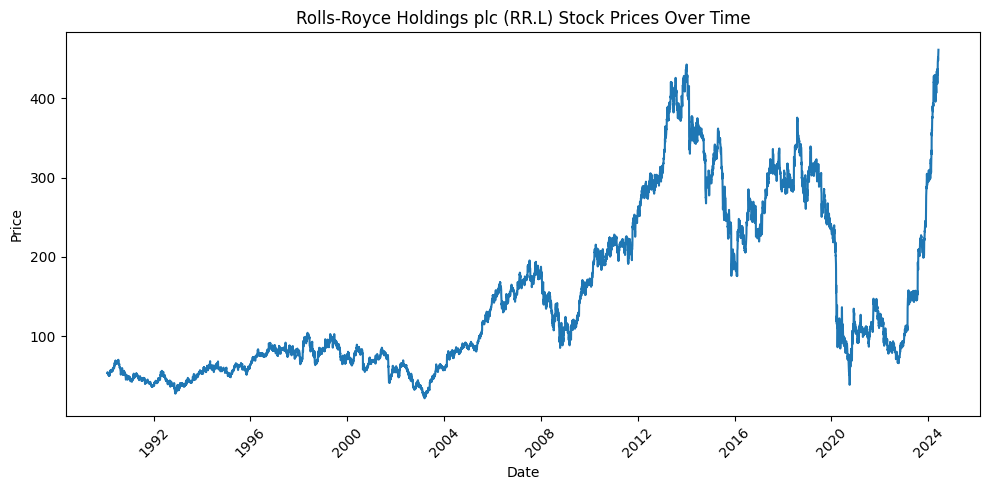

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(rolls['Date'], rolls['Close'], label='Price')
plt.title('Rolls-Royce Holdings plc (RR.L) Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
#plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# plt.savefig('rr_stock_prices_over_time.png')
#plt.close()

Interpretation:

There is a general upward trend from 1990 to around 2013-2014. A sharp decline occurred in 2020, likely due to the COVID-19 pandemic. The stock price has been relatively volatile, with several significant peaks and troughs. The most recent data shows a recovery trend after the 2020 drop.

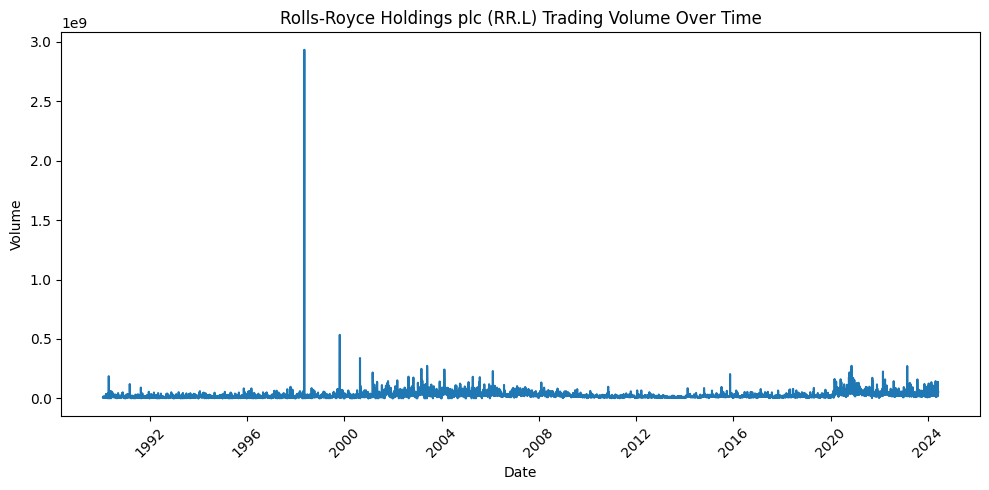

In [13]:
# Analyzing volume of stocks traded over time
plt.figure(figsize=(10, 5))
plt.plot(rolls['Date'], rolls['Volume'])
plt.title('Rolls-Royce Holdings plc (RR.L) Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Interpretation:

Trading volume has been inconsistent, with periods of high activity and relative calm. There are several spikes in volume, which could indicate significant events or news affecting the stock. The largest spike in volume appears to be around 2020, coinciding with the sharp price drop observed in the previous plot.

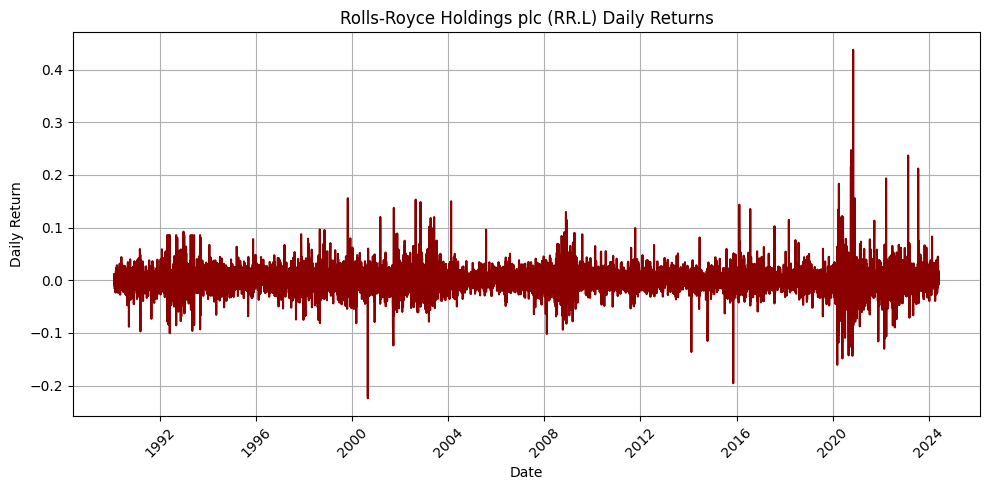

In [14]:
# Calculating daily returns
rolls['Daily_Return'] = rolls['Adj Close'].pct_change()

# Plot daily returns
plt.figure(figsize=(10, 5))
plt.plot(rolls['Date'], rolls['Daily_Return'], color='darkred')
plt.title('Rolls-Royce Holdings plc (RR.L) Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

Interpretation:

Daily returns are mostly centered around zero, which is typical for stock returns. There are several extreme positive and negative returns, indicating days of high volatility. The largest spikes in daily returns seem to coincide with the 2020 period, suggesting increased volatility during that time.

In [15]:
("Correlation Matrix:")
print(rolls[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Daily_Return']].corr())

                  Open      High       Low     Close  Adj Close    Volume  \
Open          1.000000  0.999627  0.999759  0.999601   0.992201 -0.088379   
High          0.999627  1.000000  0.999482  0.999662   0.992638 -0.083905   
Low           0.999759  0.999482  1.000000  0.999766   0.991920 -0.091539   
Close         0.999601  0.999662  0.999766  1.000000   0.992534 -0.087214   
Adj Close     0.992201  0.992638  0.991920  0.992534   1.000000 -0.069906   
Volume       -0.088379 -0.083905 -0.091539 -0.087214  -0.069906  1.000000   
Daily_Return -0.006401  0.004641  0.002973  0.012875   0.011557  0.068422   

              Daily_Return  
Open             -0.006401  
High              0.004641  
Low               0.002973  
Close             0.012875  
Adj Close         0.011557  
Volume            0.068422  
Daily_Return      1.000000  


In [16]:
rolls.corr()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily_Return
Date,1.000000,0.681233,0.685013,0.677527,0.681181,0.744657,0.110496,0.007084
Open,0.681233,1.000000,0.999627,0.999759,0.999601,0.992201,-0.088379,-0.006401
High,0.685013,0.999627,1.000000,0.999482,0.999662,0.992638,-0.083905,0.004641
Low,0.677527,0.999759,0.999482,1.000000,0.999766,0.991920,-0.091539,0.002973
Close,0.681181,0.999601,0.999662,0.999766,1.000000,0.992534,-0.087214,0.012875
Adj Close,0.744657,0.992201,0.992638,0.991920,0.992534,1.000000,-0.069906,0.011557
Volume,0.110496,-0.088379,-0.083905,-0.091539,-0.087214,-0.069906,1.000000,0.068422
Daily_Return,0.007084,-0.006401,0.004641,0.002973,0.012875,0.011557,0.068422,1.000000


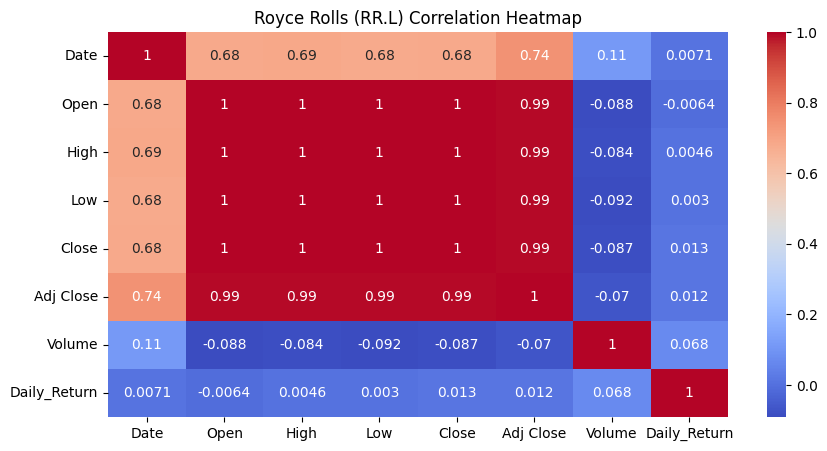

In [17]:
# Ploting correlation Matrix
plt.figure(figsize=(10, 5))
sns.heatmap(rolls.corr(), annot=True, cmap='coolwarm')
plt.title('Royce Rolls (RR.L) Correlation Heatmap')
plt.show()

Interpretation:

Open, High, Low, Close, and Adjusted Close prices are highly correlated (correlation coefficients > 0.99), which is expected for stock price data.

Volume has a weak negative correlation with price variables (around -0.07 to -0.09), suggesting that higher trading volumes are slightly associated with lower prices.

Daily Return has a very weak correlation with other variables, indicating that past prices or volumes are not strong predictors of future returns.

# Removing and Plotting Outliers

Number of outliers in Open: 0
Number of outliers in High: 1
Number of outliers in Low: 1
Number of outliers in Close: 1
Number of outliers in Adj Close: 6
Number of outliers in Volume: 41


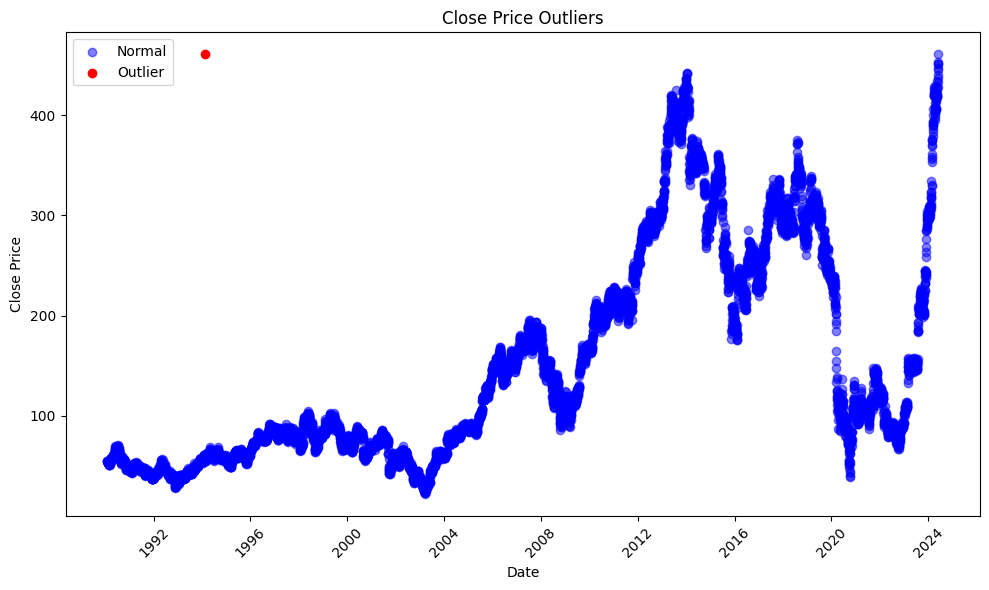

In [18]:
# Function to detect outliers using Z-score
def detect_outliers(data, threshold=3):
    z_scores = np.abs(stats.zscore(data))
    return z_scores > threshold

# Detect outliers for numerical columns
numerical_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
outliers = {}

for column in numerical_columns:
    outliers[column] = detect_outliers(rolls[column])
    print(f"Number of outliers in {column}: {outliers[column].sum()}")

# Ploting outliers for Close price
plt.figure(figsize=(10, 6))
plt.scatter(rolls['Date'], rolls['Close'], c='blue', alpha=0.5, label='Normal')
plt.scatter(rolls.index[outliers['Close']], rolls.loc[outliers['Close'], 'Close'], c='red', label='Outlier')
plt.title('Close Price Outliers')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

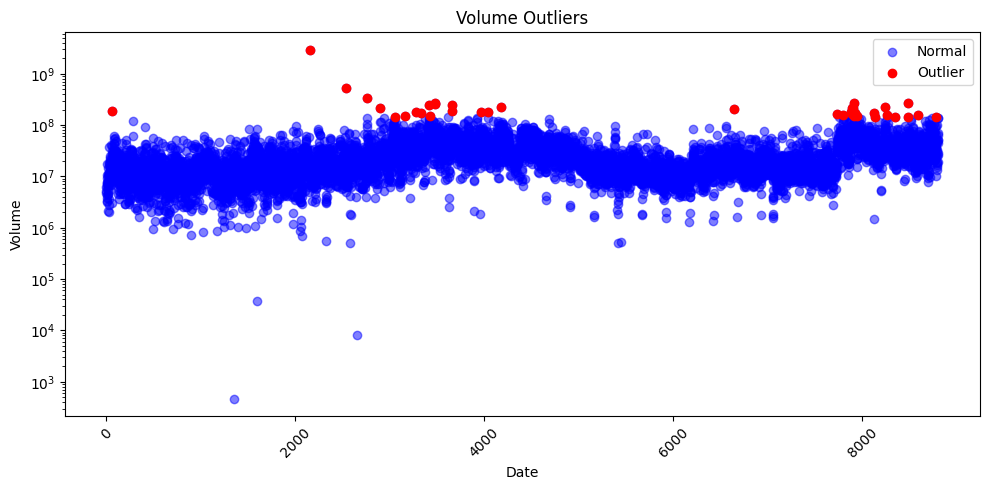

In [19]:
# Ploting outliers for Volume
plt.figure(figsize=(10, 5))
plt.scatter(rolls.index, rolls['Volume'], c='blue', alpha=0.5, label='Normal')
plt.scatter(rolls.index[outliers['Volume']], rolls.loc[outliers['Volume'], 'Volume'], c='red', label='Outlier')
plt.title('Volume Outliers')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.xticks(rotation=45)
plt.yscale('log')  # Using log scale for better visualization
plt.tight_layout()

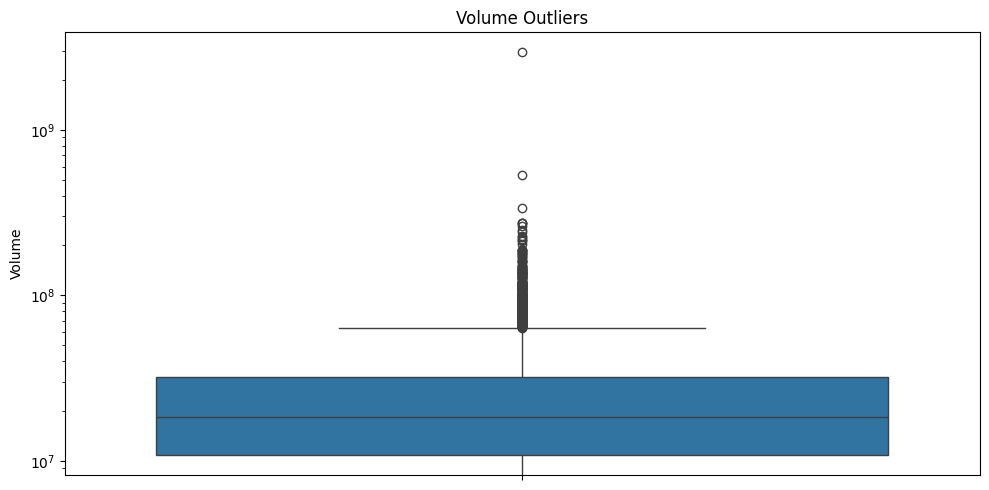

In [20]:
# Creating a box plot for 'Volume'
plt.figure(figsize=(10, 5))
sns.boxplot(data=rolls, y='Volume')
plt.title('Volume Outliers')
plt.ylabel('Volume')
plt.yscale('log')  # Use log scale for better visualization
plt.tight_layout()
plt.show()

In [21]:
# Analyzing outliers
for column in numerical_columns:
    outlier_data = rolls.loc[outliers[column], column]
    print(f"\nOutliers in {column}:")
    print(outlier_data.describe())
    print("\nTop 5 highest outliers:")
    print(outlier_data.nlargest(5))
    print("\nTop 5 lowest outliers:")
    print(outlier_data.nsmallest(5))


Outliers in Open:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Open, dtype: float64

Top 5 highest outliers:
Series([], Name: Open, dtype: float64)

Top 5 lowest outliers:
Series([], Name: Open, dtype: float64)

Outliers in High:
count      1.000000
mean     468.100006
std             NaN
min      468.100006
25%      468.100006
50%      468.100006
75%      468.100006
max      468.100006
Name: High, dtype: float64

Top 5 highest outliers:
8805    468.100006
Name: High, dtype: float64

Top 5 lowest outliers:
8805    468.100006
Name: High, dtype: float64

Outliers in Low:
count      1.000000
mean     458.600006
std             NaN
min      458.600006
25%      458.600006
50%      458.600006
75%      458.600006
max      458.600006
Name: Low, dtype: float64

Top 5 highest outliers:
8805    458.600006
Name: Low, dtype: float64

Top 5 lowest outliers:
8805    458.600006
Name: Low, dtype: float64

Outliers in Close:
count      1.

Number of outliers in Open: 0
Number of outliers in High: 1
Number of outliers in Low: 1
Number of outliers in Close: 1
Number of outliers in Adj Close: 6
Number of outliers in Volume: 41
Original dataset shape: (8806, 8)
Clean dataset shape: (8759, 8)


<ipython-input-22-5a68f3a9dfb1>:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rolls_clean = rolls_clean[~outliers[column]]
<ipython-input-22-5a68f3a9dfb1>:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rolls_clean = rolls_clean[~outliers[column]]
<ipython-input-22-5a68f3a9dfb1>:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rolls_clean = rolls_clean[~outliers[column]]
<ipython-input-22-5a68f3a9dfb1>:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rolls_clean = rolls_clean[~outliers[column]]


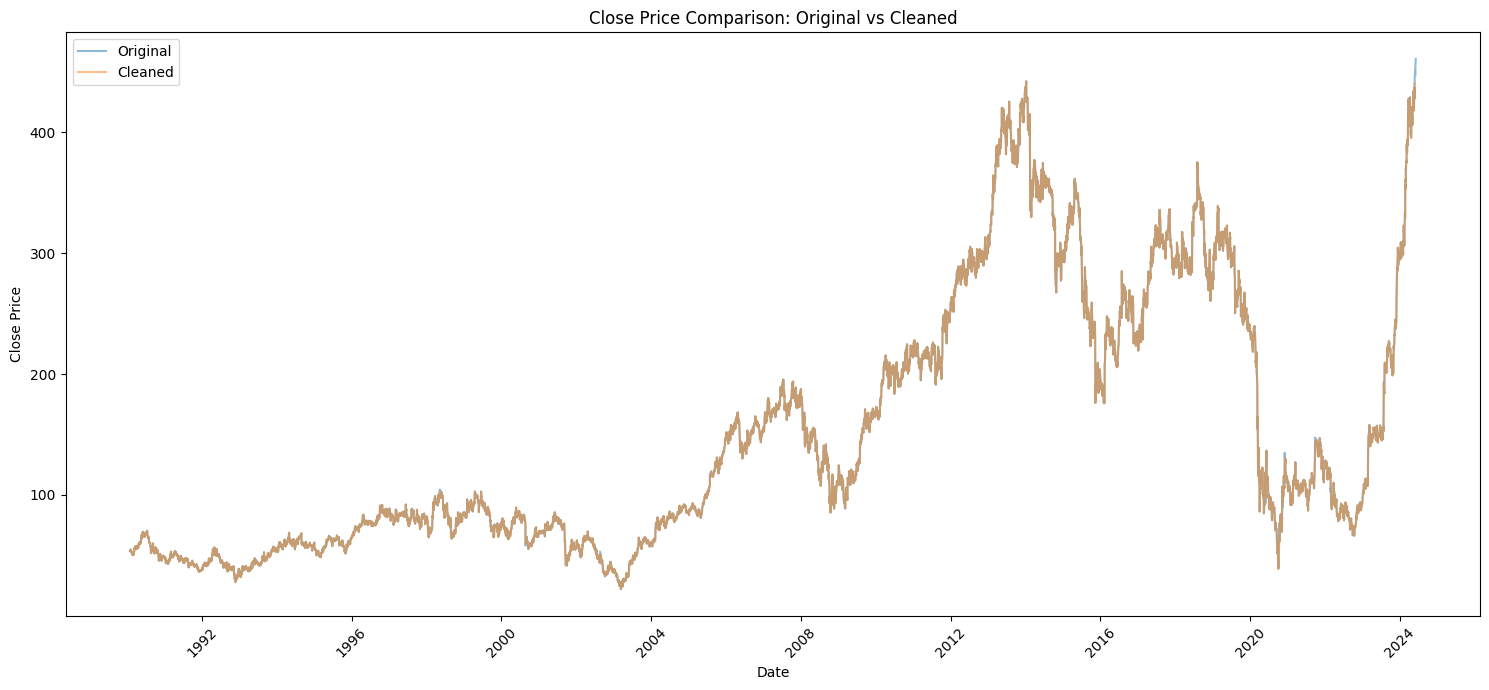

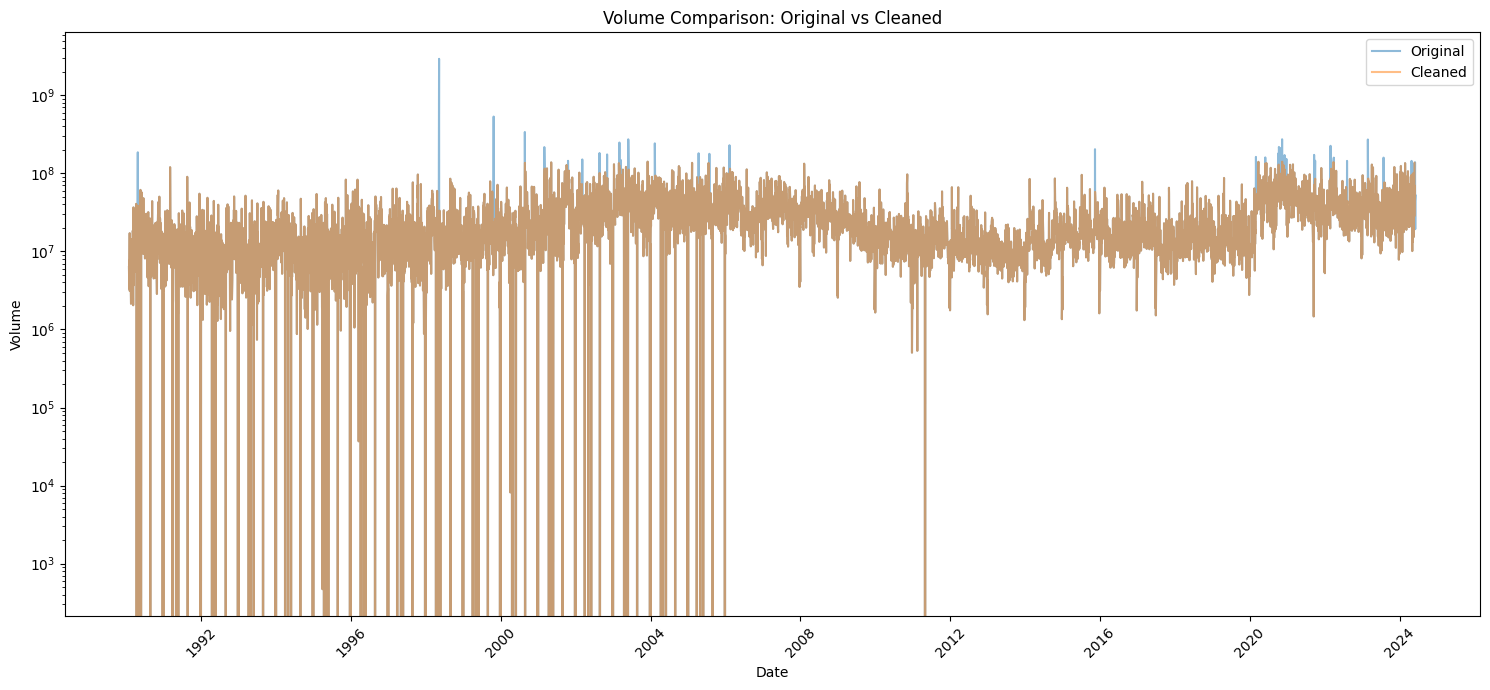

Percentage of data points removed: 0.53%
Summary statistics before outlier removal:
              Open         High          Low        Close    Adj Close  \
count  8806.000000  8806.000000  8806.000000  8806.000000  8806.000000   
mean    148.503190   150.402119   146.577036   148.517906   125.670724   
std     103.853493   104.849897   102.813588   103.858884   106.373755   
min      23.163799    23.678600    22.048500    22.048500    13.052999   
25%      65.373497    66.179953    64.515602    65.240097    38.514699   
50%     100.471001   102.650101    98.146103   100.076401    89.790592   
75%     222.201401   225.071205   219.455994   222.544495   209.377423   
max     459.299988   468.100006   458.600006   460.899994   460.899994   

             Volume  
count  8.806000e+03  
mean   2.555938e+07  
std    3.908861e+07  
min    0.000000e+00  
25%    1.083693e+07  
50%    1.840933e+07  
75%    3.203425e+07  
max    2.934018e+09  
Summary statistics after outlier removal:
         

In [22]:
# Function to detect outliers using Z-score
def detect_outliers(data, threshold=3):
    z_scores = np.abs(stats.zscore(data))
    return z_scores > threshold

# Detect outliers for numerical columns
numerical_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
outliers = {}

for column in numerical_columns:
    outliers[column] = detect_outliers(rolls[column])
    print(f"Number of outliers in {column}: {outliers[column].sum()}")

# Remove outliers
rolls_clean = rolls.copy()
for column in numerical_columns:
    rolls_clean = rolls_clean[~outliers[column]]

print(f"\
Original dataset shape: {rolls.shape}")
print(f"Clean dataset shape: {rolls_clean.shape}")

# Plot comparison for Close price
plt.figure(figsize=(15, 7))
plt.plot(rolls['Date'], rolls['Close'], label='Original', alpha=0.5)
plt.plot(rolls_clean['Date'], rolls_clean['Close'], label='Cleaned', alpha=0.5)
plt.title('Close Price Comparison: Original vs Cleaned')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('close_price_comparison.png')
plt.show()
print('\n')

# print("Close price comparison plot saved as 'close_price_comparison.png'")

# Plot comparison for Volume
plt.figure(figsize=(15, 7))
plt.semilogy(rolls['Date'], rolls['Volume'], label='Original', alpha=0.5)
plt.semilogy(rolls_clean['Date'], rolls_clean['Volume'], label='Cleaned', alpha=0.5)
plt.title('Volume Comparison: Original vs Cleaned')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('volume_comparison.png')
plt.show()

# print("Volume comparison plot saved as 'volume_comparison.png'")

# Calculate percentage of data removed
percent_removed = (1 - len(rolls_clean) / len(rolls)) * 100
print(f"\
Percentage of data points removed: {percent_removed:.2f}%")

# Display summary statistics before and after outlier removal
print("\
Summary statistics before outlier removal:")
print(rolls[numerical_columns].describe())

print("\
Summary statistics after outlier removal:")
print(rolls_clean[numerical_columns].describe())

# # Save the cleaned dataset
# df_clean.to_csv('RR.L_cleaned.csv')
# print("\
# Cleaned dataset saved as 'RR.L_cleaned.csv'")

# FEATURING ENGINEERING

Created and Added New Features to Dataframe

In [23]:
# Create new features
# 1. Moving averages
rolls['MA_5'] = rolls['Close'].rolling(window=5).mean()
rolls['MA_20'] = rolls['Close'].rolling(window=20).mean()
rolls['MA_50'] = rolls['Close'].rolling(window=50).mean()

# 2. Daily returns
rolls['Daily_Return'] = rolls['Close'].pct_change()

# 3. Volatility (20-day rolling standard deviation of returns)
rolls['Volatility'] = rolls['Daily_Return'].rolling(window=20).std()

# Display the first few rows of the updated dataframe
print(rolls.head())

# Display summary statistics of the new features
print("\
Summary statistics of new features:")
print(rolls[['MA_5', 'MA_20', 'MA_50', 'Daily_Return', 'Volatility']].describe())

        Date       Open       High        Low      Close  Adj Close   Volume  \
0 1990-01-30  53.698799  53.698799  53.698799  53.698799  25.111080  6303136   
1 1990-01-31  54.304798  54.304798  54.304798  54.304798  25.394464  4854872   
2 1990-02-01  54.304798  54.304798  54.304798  54.304798  25.394464  5243504   
3 1990-02-02  54.304798  54.304798  54.304798  54.304798  25.394464  3312486   
4 1990-02-05  54.914101  54.914101  54.914101  54.914101  25.679398  9469885   

   Daily_Return       MA_5  MA_20  MA_50  Volatility  
0           NaN        NaN    NaN    NaN         NaN  
1      0.011285        NaN    NaN    NaN         NaN  
2      0.000000        NaN    NaN    NaN         NaN  
3      0.000000        NaN    NaN    NaN         NaN  
4      0.011220  54.305459    NaN    NaN         NaN  
Summary statistics of new features:
              MA_5        MA_20        MA_50  Daily_Return   Volatility
count  8802.000000  8787.000000  8757.000000   8805.000000  8786.000000
mean    1

Ceating Lag Features

In [24]:
# Creating lagged features for the Close price
rolls['Lag_1'] = rolls['Close'].shift(1)
rolls['Lag_2'] = rolls['Close'].shift(2)
rolls['Lag_3'] = rolls['Close'].shift(3)
rolls['Lag_5'] = rolls['Close'].shift(5)
rolls['Lag_10'] = rolls['Close'].shift(10)

# Display the first few rows of the updated dataframe
print(rolls.head(15))

# Display summary statistics of the lagged features
print("\
Summary statistics of lagged features:")
print(rolls[['Lag_1', 'Lag_2', 'Lag_3', 'Lag_5', 'Lag_10']].describe())

         Date       Open       High        Low      Close  Adj Close  \
0  1990-01-30  53.698799  53.698799  53.698799  53.698799  25.111080   
1  1990-01-31  54.304798  54.304798  54.304798  54.304798  25.394464   
2  1990-02-01  54.304798  54.304798  54.304798  54.304798  25.394464   
3  1990-02-02  54.304798  54.304798  54.304798  54.304798  25.394464   
4  1990-02-05  54.914101  54.914101  54.914101  54.914101  25.679398   
5  1990-02-06  54.914101  54.914101  54.914101  54.914101  25.679398   
6  1990-02-07  54.304798  54.304798  54.304798  54.304798  25.394464   
7  1990-02-08  54.304798  54.304798  54.304798  54.304798  25.394464   
8  1990-02-09  53.395802  53.395802  53.395802  53.395802  24.969395   
9  1990-02-12  52.789700  52.789700  52.789700  52.789700  24.685951   
10 1990-02-13  52.789700  52.789700  52.789700  52.789700  24.685951   
11 1990-02-14  52.941299  52.941299  52.941299  52.941299  24.756849   
12 1990-02-15  52.486698  52.486698  52.486698  52.486698  24.54

Summary statistics of all features:
                                Date         Open         High          Low  \
count                           8806  8806.000000  8806.000000  8806.000000   
mean   2007-02-08 18:47:49.861458176   148.503190   150.402119   146.577036   
min              1990-01-30 00:00:00    23.163799    23.678600    22.048500   
25%              1998-07-08 06:00:00    65.373497    66.179953    64.515602   
50%              2006-12-24 12:00:00   100.471001   102.650101    98.146103   
75%              2015-09-13 06:00:00   222.201401   225.071205   219.455994   
max              2024-06-03 00:00:00   459.299988   468.100006   458.600006   
std                              NaN   103.853493   104.849897   102.813588   

             Close    Adj Close        Volume  Daily_Return         MA_5  \
count  8806.000000  8806.000000  8.806000e+03   8805.000000  8802.000000   
mean    148.517906   125.670724  2.555938e+07      0.000542   148.469666   
min      22.048500    13

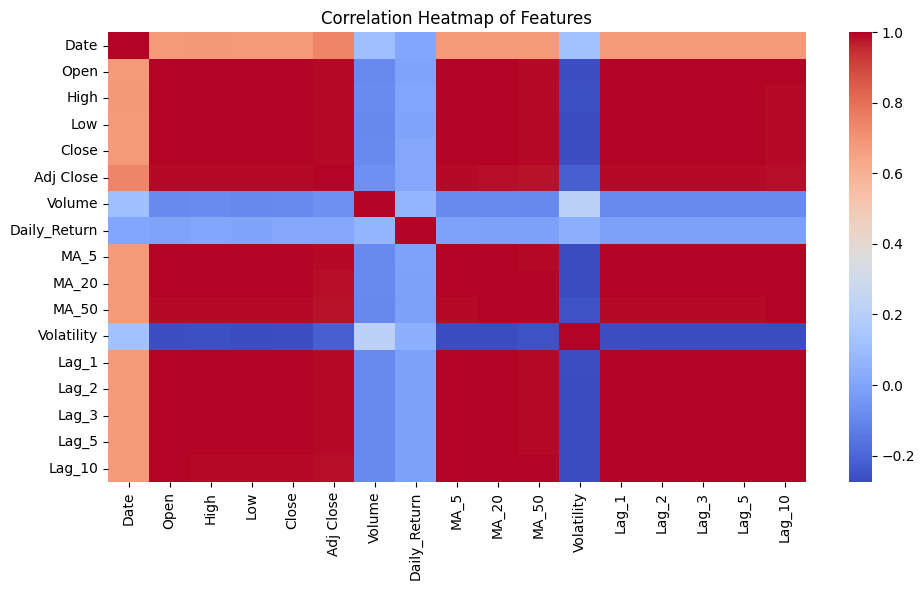

<ipython-input-25-31f0c0f5335e>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


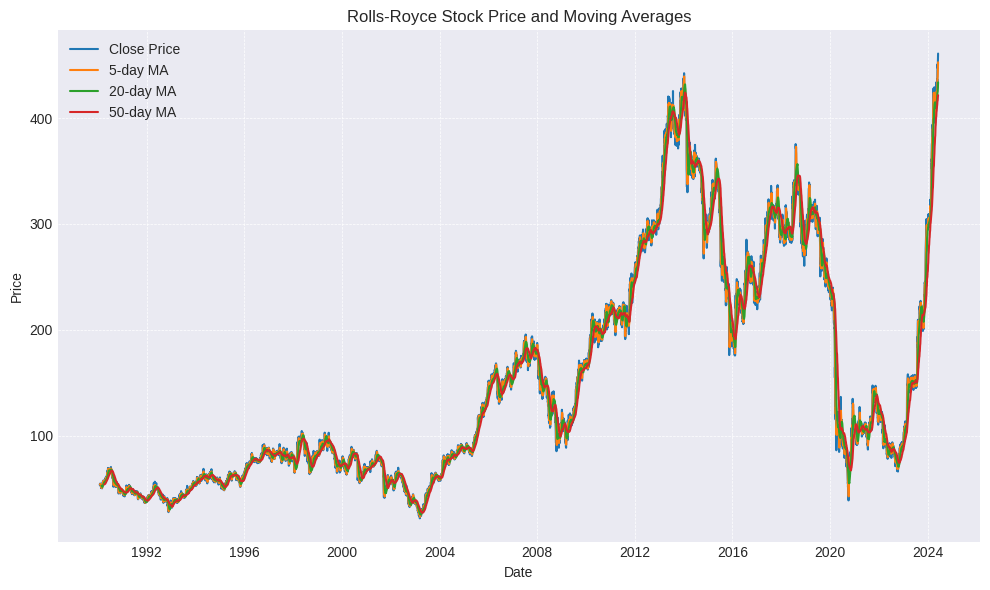

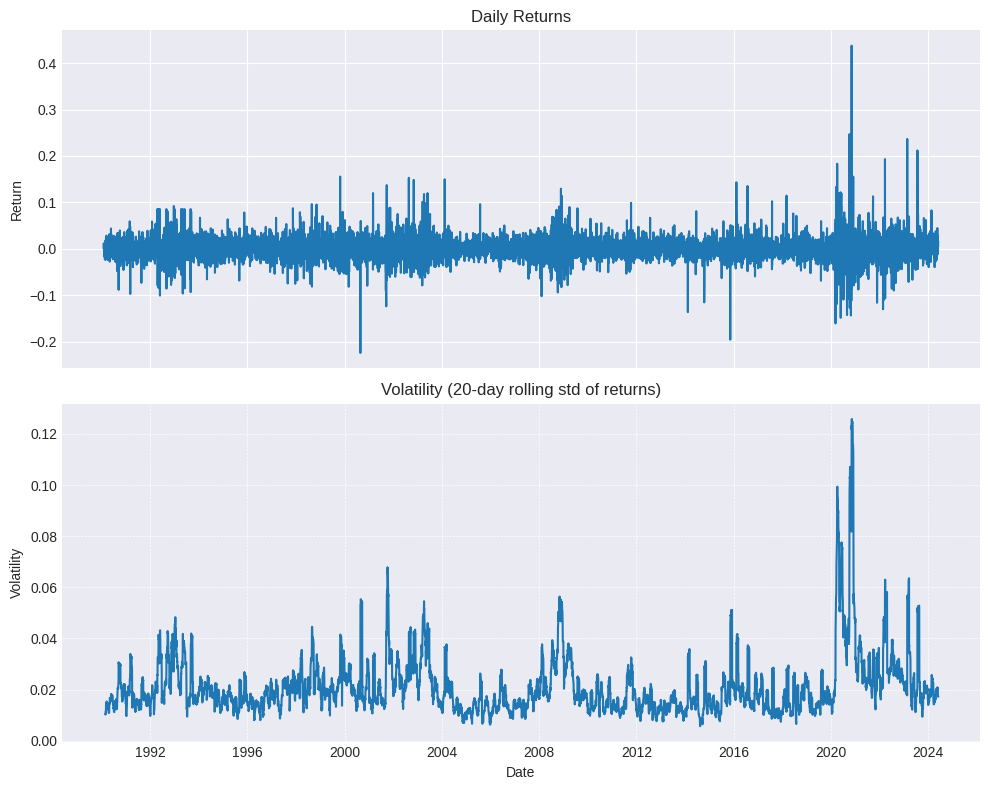

In [25]:
# Displaying summary statistics of all features
print("Summary statistics of all features:")
print(rolls.describe())

# Creating a correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(rolls.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap of Features')
plt.tight_layout()
#plt.savefig('correlation_heatmap.png')
plt.show()
print('\n')

# Ploting the time series of Close price and its moving averages
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10, 6))
plt.plot(rolls['Date'], rolls['Close'], label='Close Price')
plt.plot(rolls['Date'], rolls['MA_5'], label='5-day MA')
plt.plot(rolls['Date'], rolls['MA_20'], label='20-day MA')
plt.plot(rolls['Date'], rolls['MA_50'], label='50-day MA')
plt.title('Rolls-Royce Stock Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
#plt.savefig('price_and_moving_averages.png')
plt.show()

# Ploting the daily returns and volatility
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
ax1.plot(rolls['Date'], rolls['Daily_Return'])
ax1.set_title('Daily Returns')
ax1.set_ylabel('Return')
ax2.plot(rolls['Date'], rolls['Volatility'])
ax2.set_title('Volatility (20-day rolling std of returns)')
ax2.set_ylabel('Volatility')
ax2.set_xlabel('Date')
plt.tight_layout()
plt.grid(True, linestyle='--', linewidth=0.5)
#plt.savefig('returns_and_volatility.png')
plt.show()

In [26]:
# Creating additional features
# Exponential Moving Averages (EMA)
rolls['EMA_12'] = rolls['Close'].ewm(span=12, adjust=False).mean()
rolls['EMA_26'] = rolls['Close'].ewm(span=26, adjust=False).mean()

# Relative Strength Index (RSI)
window_length = 14
close = rolls['Close']
delta = close.diff()
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0
roll_up = up.rolling(window_length).mean()
roll_down = down.abs().rolling(window_length).mean()
rs = roll_up / roll_down
rolls['RSI'] = 100.0 - (100.0 / (1.0 + rs))

# Example: Bollinger Bands
window = 20
rolling_mean = rolls['Close'].rolling(window).mean()
rolling_std = rolls['Close'].rolling(window).std()
rolls['Bollinger_High'] = rolling_mean + (rolling_std * 2)
rolls['Bollinger_Low'] = rolling_mean - (rolling_std * 2)

Summary statistics of the new engineered features:
            EMA_12       EMA_26          RSI  Bollinger_High  Bollinger_Low
count  8806.000000  8806.000000  8792.000000     8787.000000    8787.000000
mean    148.274574   147.980814    51.265539      157.743025     138.866117
std     103.461510   103.005166    16.387056      108.199273      98.833077
min      24.753171    26.720025     3.349047       29.261661      21.777000
25%      65.281533    64.810436    39.635543       70.508308      61.316786
50%      99.837635   100.932993    51.878697      111.792382      88.989921
75%     220.762414   219.280777    62.944714      235.718313     210.581306
max     443.296049   432.069282   100.000000      461.085686     420.462673


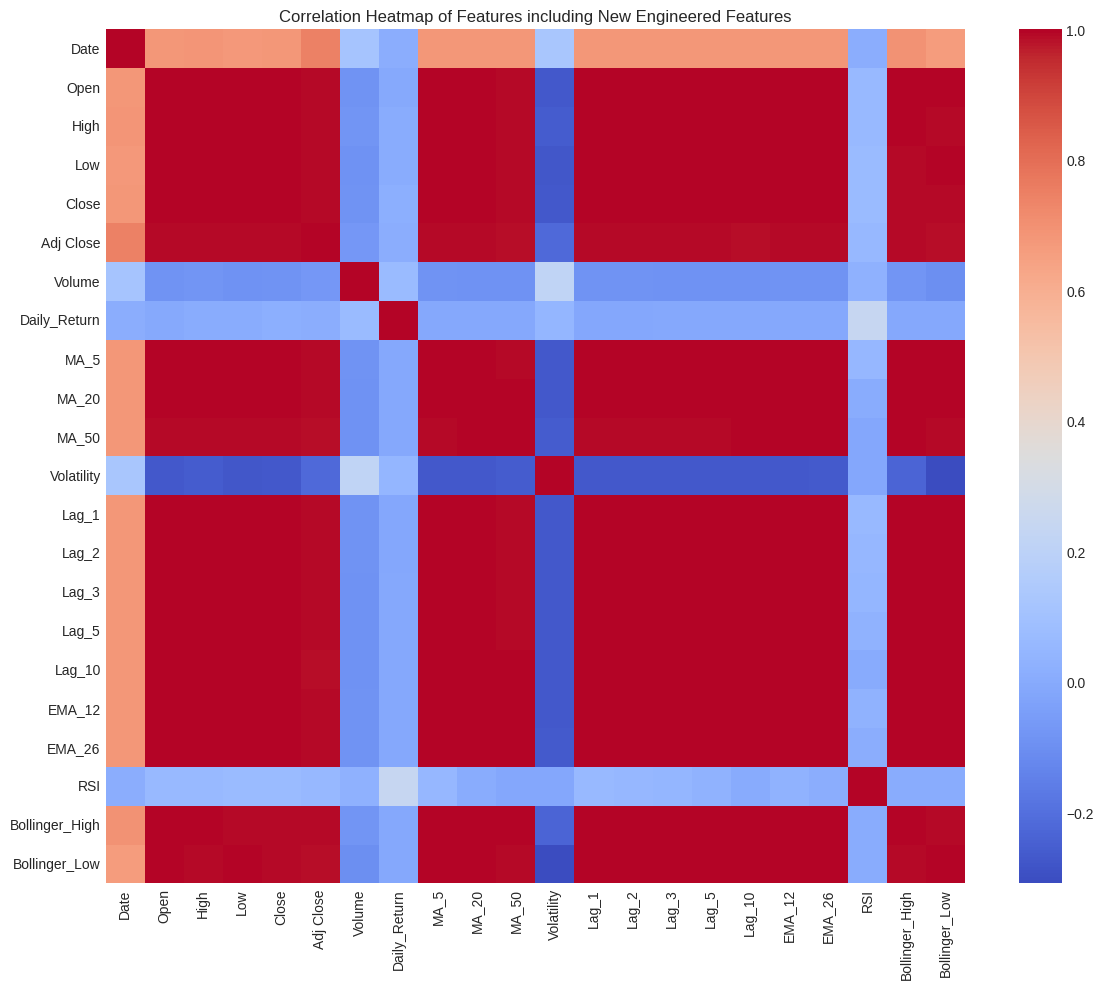

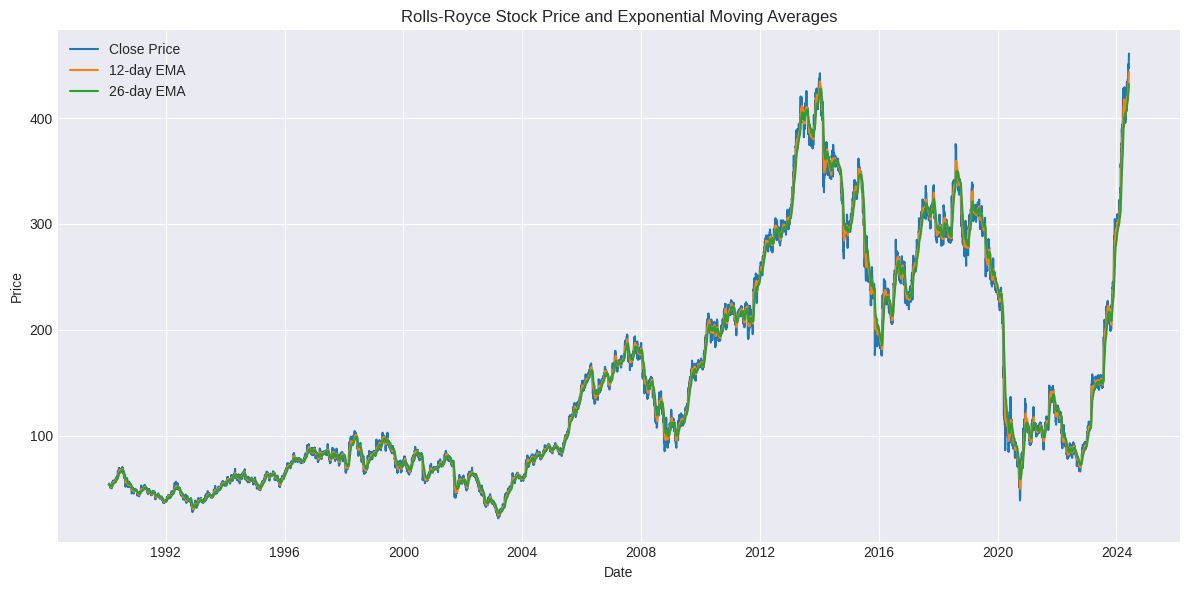

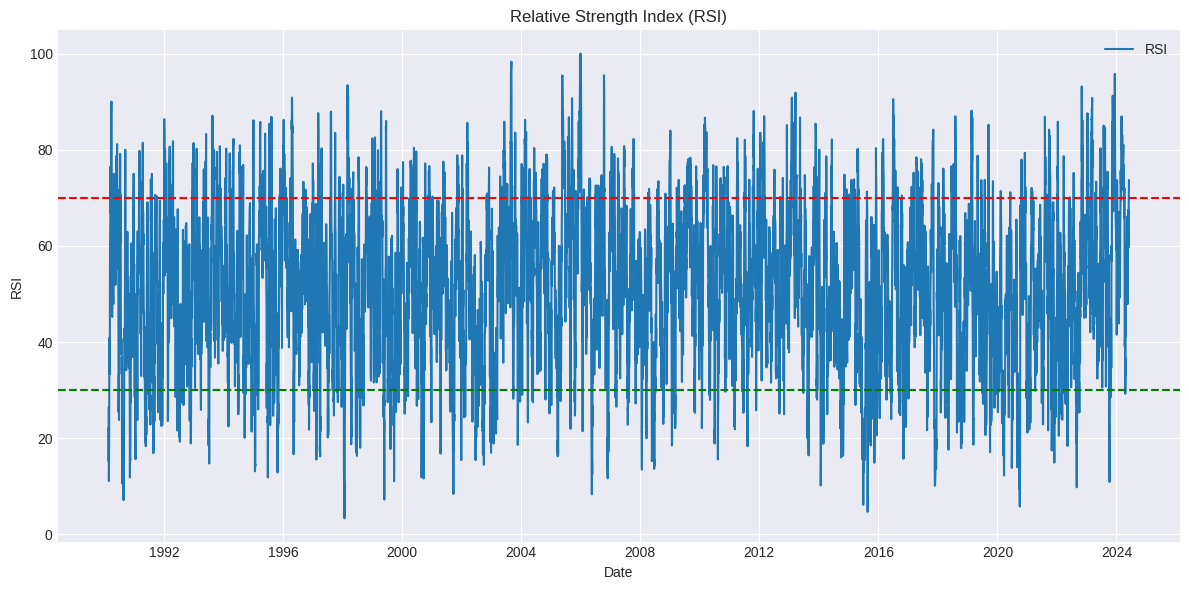

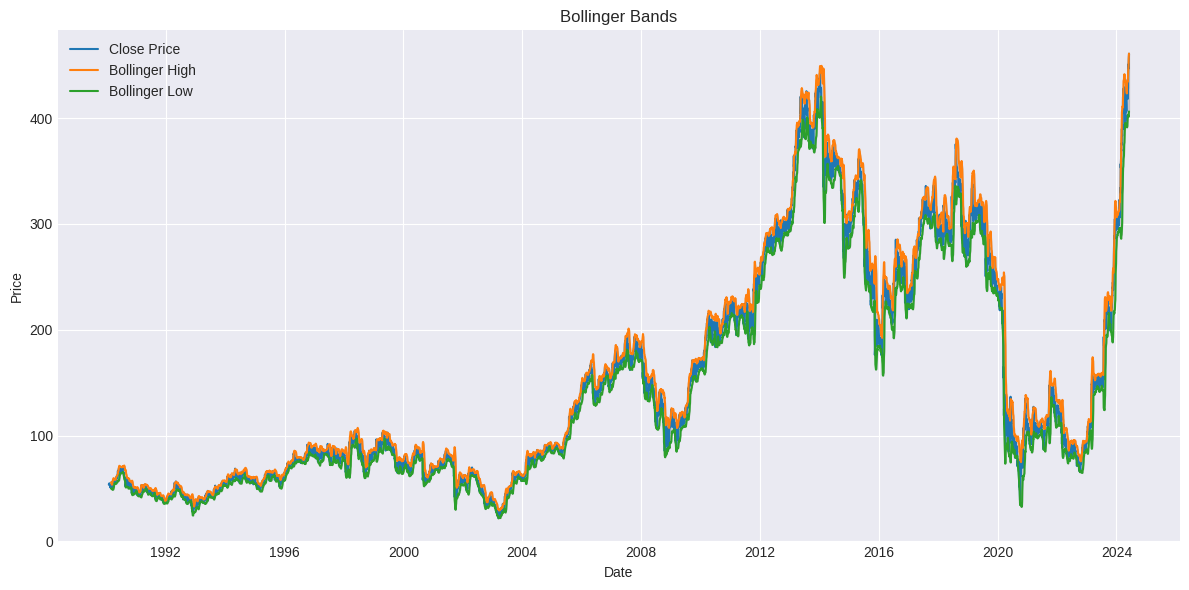

In [27]:
# Display summary statistics of the new features
print("Summary statistics of the new engineered features:")
print(rolls[['EMA_12', 'EMA_26', 'RSI', 'Bollinger_High', 'Bollinger_Low']].describe())

# Create a correlation heatmap including the new features
plt.figure(figsize=(12, 10))
sns.heatmap(rolls.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap of Features including New Engineered Features')
plt.tight_layout()
#plt.savefig('correlation_heatmap_new_features.png')
plt.show()

# Plot the time series of Close price and its EMAs
plt.figure(figsize=(12, 6))
plt.plot(rolls['Date'], rolls['Close'], label='Close Price')
plt.plot(rolls['Date'], rolls['EMA_12'], label='12-day EMA')
plt.plot(rolls['Date'], rolls['EMA_26'], label='26-day EMA')
plt.title('Rolls-Royce Stock Price and Exponential Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
#plt.savefig('price_and_emas.png')
plt.show()

# Plot the RSI
plt.figure(figsize=(12, 6))
plt.plot(rolls['Date'], rolls['RSI'], label='RSI')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.tight_layout()
#plt.savefig('rsi.png')
plt.show()

# Plot the Bollinger Bands
plt.figure(figsize=(12, 6))
plt.plot(rolls['Date'], rolls['Close'], label='Close Price')
plt.plot(rolls['Date'], rolls['Bollinger_High'], label='Bollinger High')
plt.plot(rolls['Date'], rolls['Bollinger_Low'], label='Bollinger Low')
plt.fill_between(rolls['Date'], rolls['Bollinger_Low'], rolls['Bollinger_High'], color='gray', alpha=0.3)
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
#plt.savefig('bollinger_bands.png')
plt.show()

**TIME SERIES ANALYSIS and FORECASTING**

Decompose Time Series

Time series decomposition is used to separate the data into trend, seasonality, and residual components. This to understanding the underlying patterns in the data.

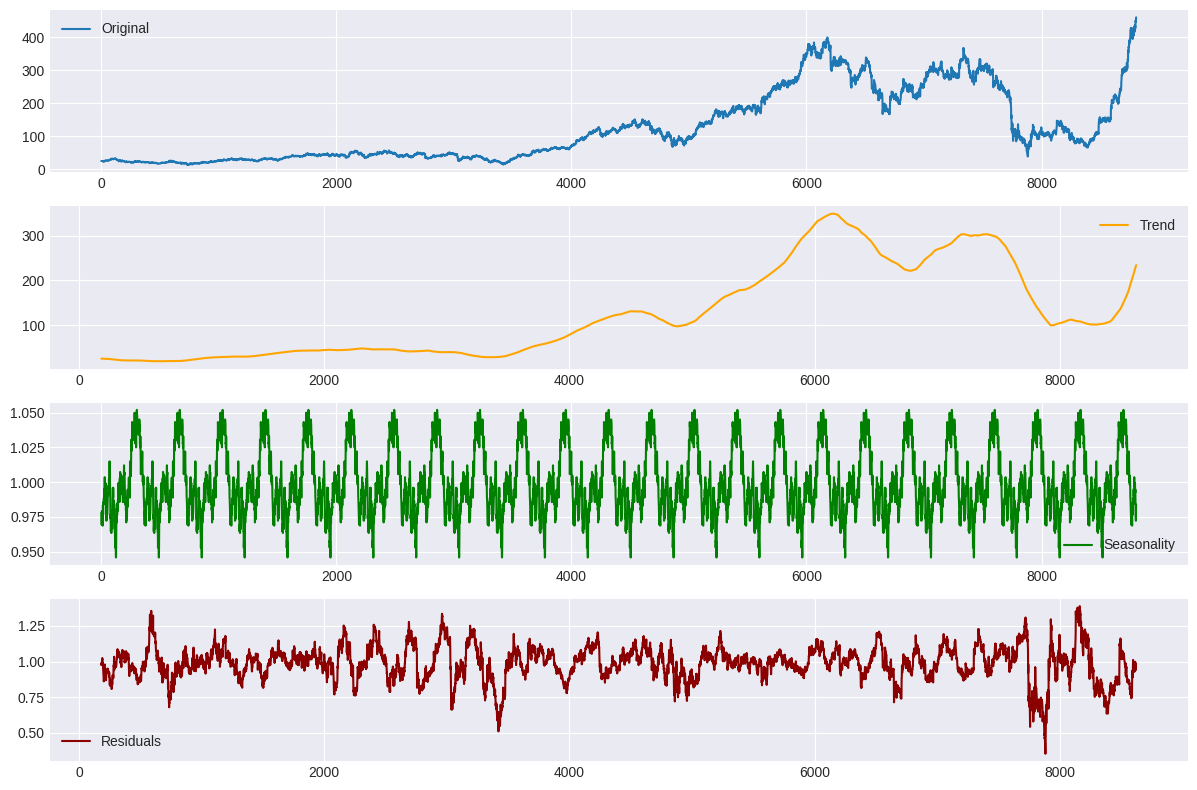

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

# Decompose the Time Series
decomposition = sm.tsa.seasonal_decompose(rolls['Adj Close'], model='multiplicative', period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotting Decomposed Components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(rolls['Adj Close'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='orange')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='darkred')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Applying Time Series Forecasting Model:

ARIMA (Auto-Regressive Integrated Moving Average) Model for Forecasting, and Evaluating performances using MAE RMSE and R-square

In [29]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

ARIMA Model Performance:
MAE:  118.13127151803572
RMSE:  147.68283142386727
R-squared:  -1.082098055947046


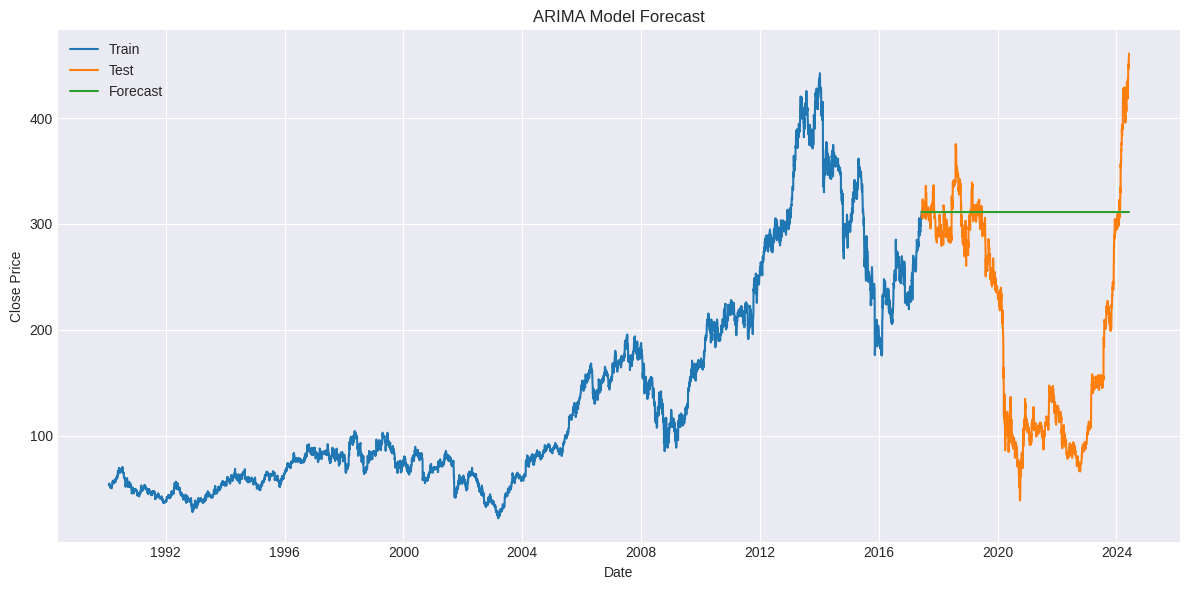

In [30]:
# Split the data into training and test sets
train_size = int(len(rolls) * 0.8)
#train, test = rolls[['Date', 'Close']][:train_size], rolls[['Date','Close']][train_size:]
train, test = rolls['Close'][:train_size], rolls['Close'][train_size:]

# Fiting the ARIMA model
model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()

# Forecasting
forecast = model_fit.forecast(steps=len(test))

# Evaluating the model
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
r2 = r2_score(test, forecast)

print("ARIMA Model Performance:")
print("MAE: ", mae)
print("RMSE: ", rmse)
print("R-squared: ", r2_score(test, forecast))

# Ploting the forecast
# For plotting, you'll need to adjust the date selection as well
plt.figure(figsize=(12, 6))
plt.plot(rolls['Date'][:train_size], train, label='Train')
plt.plot(rolls['Date'][train_size:], test, label='Test')

# Generating date range for forecasting
plt.plot(rolls['Date'][train_size:], forecast, label='Forecast')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

# MACHINE LEARNING MODEL

In [31]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

In [32]:
rolls.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Daily_Return,MA_5,MA_20,...,Lag_1,Lag_2,Lag_3,Lag_5,Lag_10,EMA_12,EMA_26,RSI,Bollinger_High,Bollinger_Low
0,1990-01-30,53.698799,53.698799,53.698799,53.698799,25.111080,6303136,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,53.698799,53.698799,NaN,NaN,NaN
1,1990-01-31,54.304798,54.304798,54.304798,54.304798,25.394464,4854872,0.011285,NaN,NaN,...,53.698799,NaN,NaN,NaN,NaN,53.792030,53.743688,NaN,NaN,NaN
2,1990-02-01,54.304798,54.304798,54.304798,54.304798,25.394464,5243504,0.000000,NaN,NaN,...,54.304798,53.698799,NaN,NaN,NaN,53.870917,53.785252,NaN,NaN,NaN
3,1990-02-02,54.304798,54.304798,54.304798,54.304798,25.394464,3312486,0.000000,NaN,NaN,...,54.304798,54.304798,53.698799,NaN,NaN,53.937668,53.823736,NaN,NaN,NaN
4,1990-02-05,54.914101,54.914101,54.914101,54.914101,25.679398,9469885,0.011220,54.305459,NaN,...,54.304798,54.304798,54.304798,NaN,NaN,54.087888,53.904504,NaN,NaN,NaN


In [33]:
# Select features for modeling
features = ['Open', 'High', 'Low', 'Volume', 'EMA_12', 'EMA_26', 'RSI', 'Bollinger_High', 'Bollinger_Low']
target = 'Close'

X = rolls[features]
y = rolls[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values using the mean strategy
imputer = SimpleImputer(strategy='mean') #
X_train_imputed = imputer.fit_transform(X_train)  # Fit and transform training data
X_test_imputed = imputer.transform(X_test)  # Transform testing data


# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

print("Data preparation completed.")
print("Training set shape:", X_train_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)

Data preparation completed.
Training set shape: (7044, 9)
Testing set shape: (1762, 9)


Applying Linear Regression Model

In [34]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_rsme = np.sqrt(lr_mse)
lr_r2 = r2_score(y_test, lr_pred)

print("Linear Regression Results:")
print("MSE: " + str(lr_mse))
print("RSME: " + str(lr_rsme))
print("R2 Score: " + str(lr_r2))

Linear Regression Results:
MSE: 3.0741146660792817
RSME: 1.7533153356083102
R2 Score: 0.9997117002926541


Applying Random Forest Model

In [35]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_rsme = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_pred)

print("\
Random Forest Results:")
print("MSE: " + str(rf_mse))
print("RSME: " + str(rf_rsme))
print("R2 Score: " + str(rf_r2))

Random Forest Results:
MSE: 3.1893639548664825
RSME: 1.7858790426192035
R2 Score: 0.9997008918681682
